# Practical PyTorch: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level RNN to classify
words. We will build our NLP model from scratch, in particular not using
many of the convenience functions of `torchtext` to better understand and
see the model in a relatively low level.

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

## Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

In [1]:
import glob
import os
import unicodedata
import string

all_filenames = glob.glob('./data/names/*.txt')  # find all files
all_letters = string.ascii_letters + " .,;'"  # 52 letters + 5 special characters
n_letters = len(all_letters)  # 57

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


We'll end up with a dictionary mapping each **category** (language) to a list of **lines** (names), `{language: [names ...]}`.

In [2]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in all_filenames:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# peak at a data sample
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Variables `all_categories` and `n_categories` save the category names and the number of categories

In [3]:
print('n_categories =', n_categories)
print(all_categories)

n_categories = 18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


## Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a ***one-hot vector*** of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [4]:
import torch

# set computing device
device = "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters).to(device)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters).to(device)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('d'))

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [6]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


## Creating the RNN

Creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself, which means we can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.to(device)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

### Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `line_to_tensor` instead of `letter_to_tensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [9]:
input = lineToTensor('Albert')
hidden = rnn.initHidden()

output, next_hidden = rnn(input[0], hidden)
print('output.size =', output.size())
print(output)

output.size = torch.Size([1, 18])
tensor([[-2.9153, -2.9044, -2.9047, -2.9624, -3.0204, -2.9305, -2.9275, -2.9539,
         -2.7650, -2.8733, -2.9236, -2.8707, -2.7954, -2.8482, -2.8455, -2.8594,
         -2.8688, -2.8886]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

## Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


We will also want a quick way to get a random training example (a name and its language):

In [11]:
import random

def randomTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '| line =', line)

category = Korean | line = Chi
category = Japanese | line = Hiyama
category = Czech | line = Kafka
category = Czech | line = Stluka
category = Czech | line = Ustohal
category = Irish | line = Mooney
category = Portuguese | line = Matos
category = Scottish | line = Sinclair
category = Chinese | line = Kui
category = English | line = Chamberlain


## Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`. (so actually we are using `cross-entrophy` loss)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [12]:
learning_rate = 0.005 # use a low learning rate
loss_func = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_func(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate (SGD algorithm)
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# save trained model
torch.save(rnn, 'char-rnn-classification.pt')

5000 5% (0m 6s) 2.7372 Wojda / Japanese ✗ (Polish)
10000 10% (0m 13s) 1.9297 Aucciello / Spanish ✗ (Italian)
15000 15% (0m 20s) 1.1895 Sai / Chinese ✗ (Vietnamese)
20000 20% (0m 26s) 1.1779 Do / Vietnamese ✓
25000 25% (0m 33s) 0.8139 Bao / Chinese ✓
30000 30% (0m 39s) 2.1387 Caiazzo / Portuguese ✗ (Italian)
35000 35% (0m 46s) 2.5635 Opayne / French ✗ (English)
40000 40% (0m 53s) 0.9476 Nie / Chinese ✓
45000 45% (0m 59s) 0.2494 Yuan / Chinese ✓
50000 50% (1m 6s) 1.4255 O'Hanlon / Scottish ✗ (Irish)
55000 55% (1m 13s) 0.0505 Iwahara / Japanese ✓
60000 60% (1m 20s) 3.0539 Seif / Korean ✗ (Arabic)
65000 65% (1m 26s) 1.6799 OuYang / Korean ✗ (Chinese)
70000 70% (1m 33s) 0.2955 Hudiev / Russian ✓
75000 75% (1m 40s) 3.9904 Roldan / Irish ✗ (Spanish)
80000 80% (1m 46s) 2.0174 Waltz / Scottish ✗ (German)
85000 85% (1m 53s) 0.9309 Zhang / Chinese ✓
90000 90% (2m 0s) 0.1878 Minushkin / Russian ✓
95000 95% (2m 6s) 2.8009 Duncan / English ✗ (Scottish)
100000 100% (2m 13s) 2.7074 Pakhtel / Czech ✗ (

## Plotting training loss

Plotting the historical loss from `all_losses` shows the network learning:

Avg loss: 1.25


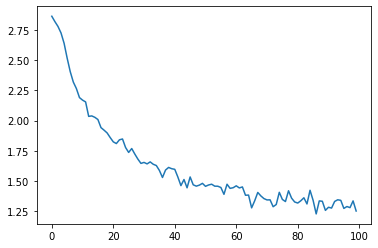

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

print('Avg loss: %.2f' % all_losses[-1])
plt.figure()
plt.plot(all_losses)
plt.show()

## Evaluating the Results

To see how well the network performs on different categories, we will create a **confusion matrix**, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

Accuracy: 0.60


<ipython-input-15-d07164c46a33>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-15-d07164c46a33>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


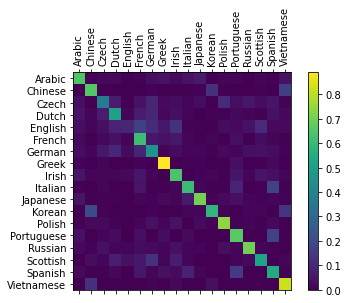

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_test_case = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
correct_count = 0
for i in range(n_test_case):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    if category_i == guess_i:
        correct_count += 1
accuracy = correct_count / n_test_case
print('Accuracy: %.2f' % accuracy)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

## Running on User Input

In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# load saved model
rnn = torch.load('char-rnn-classification.pt')

predict('Xin')


> Xin
(-0.23) Chinese
(-2.25) Korean
(-3.43) Vietnamese
